In [1]:
import os
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torchvision
import tifffile as tiff
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from copy import deepcopy
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import random

In [2]:
# Set seed for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set seed
set_seed(42)

In [3]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Custom Dataset class
class ImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = [os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.endswith('.tiff')]
        self.resize_transform = transforms.Resize((96,96))
    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Ensure the image has 3 layers (channels)
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} does not have exactly 3 layers.")
        
        # Normalize the 16-bit image to [0, 1]
        image = image.astype(np.float32) / 65535.0
        
        # Calculate sharpness for each layer
        sharpness_scores = []
        for i in range(3):
            layer = image[i]
            gy, gx = np.gradient(layer)
            gnorm = np.sqrt(gx**2 + gy**2)
            sharpness = np.average(gnorm)
            sharpness_scores.append(sharpness)
        

        # Find the index of the sharpest layer
        sharpest_layer_index = np.argmax(sharpness_scores)
        
        # Determine the anchor (sharpest layer) and the other two layers (augmentations)
        anchor = image[sharpest_layer_index]
        other_indices = [i for i in range(3) if i != sharpest_layer_index]
        augmentation1 = image[other_indices[0]]
        augmentation2 = image[other_indices[1]]

        # Convert to a torch tensor and add channel dimension
        anchor = torch.tensor(anchor, dtype=torch.float32).unsqueeze(0)
        img1 = torch.tensor(augmentation1, dtype=torch.float32).unsqueeze(0)
        img2 = torch.tensor(augmentation2, dtype=torch.float32).unsqueeze(0)
        
        # Apply resize transform
        anchor = self.resize_transform(anchor)
        img1 = self.resize_transform(img1)
        img2 = self.resize_transform(img2)


        # Apply resize transform
        anchor = self.resize_transform(anchor)
        img1 = self.resize_transform(img1)
        img2 = self.resize_transform(img2)
        
        return img1, img2

# Create the dataset
image_dir = r"../../tiff_experiment_unsupervised_data/combined"
dataset = ImageDataset(image_dir=image_dir)
batch_size = 16

# Function to split dataset with explicit percentage
def split_dataset(dataset, val_percentage):
    val_size = int(len(dataset) * val_percentage)
    train_size = len(dataset) - val_size
    return random_split(dataset, [train_size, val_size])

# Split the dataset with 20% for validation
val_percentage = 0.2
train_dataset, val_dataset = split_dataset(dataset, val_percentage)

# Define DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False, pin_memory=True, num_workers=0) #num_workers =os.cpu_count()
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=0)

In [5]:
for i, (img1, img2) in enumerate(train_loader):
    print(f"Batch {i}:")
    print(f"  Image1: {img1.shape}")
    print(f"  Image2: {img2.shape}")
    break

Batch 0:
  Image1: torch.Size([16, 1, 96, 96])
  Image2: torch.Size([16, 1, 96, 96])


In [6]:
def plot_curves(train_losses, val_losses, train_top1_accs, val_top1_accs, train_top5_accs, val_top5_accs, train_mean_pos, val_mean_pos):
    epochs = range(1, len(train_losses) + 1)
    
    # Plot loss
    plt.figure(figsize=(16, 10))
    
    plt.subplot(2, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
    plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Top-1 accuracy
    plt.subplot(2, 2, 2)
    plt.plot(epochs, train_top1_accs, 'bo-', label='Training Top-1 Accuracy')
    plt.plot(epochs, val_top1_accs, 'ro-', label='Validation Top-1 Accuracy')
    plt.title('Training and Validation Top-1 Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Top-1 Accuracy (%)')
    plt.legend()

    # Plot Top-5 accuracy
    plt.subplot(2, 2, 3)
    plt.plot(epochs, train_top5_accs, 'bo-', label='Training Top-5 Accuracy')
    plt.plot(epochs, val_top5_accs, 'ro-', label='Validation Top-5 Accuracy')
    plt.title('Training and Validation Top-5 Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Top-5 Accuracy (%)')
    plt.legend()

    # Plot Mean Positive Position
    plt.subplot(2, 2, 4)
    plt.plot(epochs, train_mean_pos, 'bo-', label='Training Mean Positive Position')
    plt.plot(epochs, val_mean_pos, 'ro-', label='Validation Mean Positive Position')
    plt.title('Training and Validation Mean Positive Position')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Position')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [7]:
# Define the SimCLR model class (plain PyTorch version)
class SimCLR(nn.Module):
    def __init__(self, hidden_dim, lr, temperature, weight_decay):
        super().__init__()
        self.temperature = temperature
        
        # Load the pretrained ResNet-18 model
        self.convnet = torchvision.models.resnet18(weights='ResNet18_Weights.DEFAULT')
        
        self.convnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        # Modify the fully connected layer
        self.convnet.fc = nn.Sequential(
            nn.Linear(self.convnet.fc.in_features, 4 * hidden_dim),  # Linear layer with 4*hidden_dim output
            nn.ReLU(inplace=True),
            nn.Linear(4 * hidden_dim, 20)  # Output layer with hidden_dim output
        )

        self.optimizer = optim.AdamW(self.parameters(), lr=lr, weight_decay=weight_decay)
        self.lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=50, eta_min=lr / 50)

    def forward(self, x):
        return self.convnet(x)

    def info_nce_loss(self, imgs1, imgs2, device):

        imgs = torch.cat((imgs1, imgs2), dim=0)  # Concatenate along the batch dimension
        imgs = imgs.to(device)  # Move images to the device

        # Encode all images
        feats = self.forward(imgs)
    
        # Calculate cosine similarity
        cos_sim = nn.functional.cosine_similarity(feats[:, None, :], feats[None, :, :], dim=-1)
    
        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
    
        # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0] // 2, dims=0)
    
        # Normalize similarity scores by temperature
        cos_sim = cos_sim / self.temperature

        # InfoNCE loss
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        # Accuracy calculations
        # Create a combination of positive and negative similarities for ranking
        comb_sim = torch.cat([cos_sim[pos_mask][:, None],  # Positive example in first position
                          cos_sim.masked_fill(pos_mask, -9e15)], dim=-1)
    
        # Sort and get the ranking position of the positive example
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
    
        # Compute accuracy metrics
        top1_acc = (sim_argsort == 0).float().mean()  # Top-1 accuracy
        top5_acc = (sim_argsort < 5).float().mean()   # Top-5 accuracy
        mean_pos = 1 + sim_argsort.float().mean()     # Mean position of the positive example

        return nll, top1_acc, top5_acc, mean_pos

    def train_epoch(self, train_loader, device):
        self.train()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        for batch in tqdm(train_loader, desc="Training", leave=False):
            imgs1, imgs2 = batch
            imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device
        
            self.optimizer.zero_grad()

            # Calculate loss and accuracy metrics
            loss, top1_acc, top5_acc, mean_pos = self.info_nce_loss(imgs1, imgs2, device)

            loss.backward()
            self.optimizer.step()
            self.lr_scheduler.step()

            # Accumulate metrics
            total_loss += loss.item()
            total_top1_acc += top1_acc.item()
            total_top5_acc += top5_acc.item()
            total_mean_pos += mean_pos.item()

        avg_loss = total_loss / len(train_loader)
        avg_top1_acc = total_top1_acc / len(train_loader)
        avg_top5_acc = total_top5_acc / len(train_loader)
        avg_mean_pos = total_mean_pos / len(train_loader)

        return avg_loss, avg_top1_acc, avg_top5_acc, avg_mean_pos

    def validate_epoch(self, val_loader, device):
        self.eval()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validating", leave=False):
                imgs1, imgs2 = batch
                imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device

                # Calculate loss and accuracy metrics
                loss, top1_acc, top5_acc, mean_pos = self.info_nce_loss(imgs1, imgs2, device)

                # Accumulate metrics
                total_loss += loss.item()
                total_top1_acc += top1_acc.item()
                total_top5_acc += top5_acc.item()
                total_mean_pos += mean_pos.item()

        avg_loss = total_loss / len(val_loader)
        avg_top1_acc = total_top1_acc / len(val_loader)
        avg_top5_acc = total_top5_acc / len(val_loader)
        avg_mean_pos = total_mean_pos / len(val_loader)

        return avg_loss, avg_top1_acc, avg_top5_acc, avg_mean_pos



In [8]:
def train_simclr(batch_size, max_epochs=50, hidden_dim=128, lr=5e-4, temperature=0.07, weight_decay=1e-4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    model = SimCLR(hidden_dim=hidden_dim, lr=lr, temperature=temperature, weight_decay=weight_decay).to(device)
    
    # Lists to store the metrics
    train_losses, val_losses = [], []
    train_top1_accs, val_top1_accs = [], []
    train_top5_accs, val_top5_accs = [], []
    train_mean_pos, val_mean_pos = [], []

    start_time = time.time()

    for epoch in range(max_epochs):
        epoch_start_time = time.time()

        # Train and validate the model
        train_loss, train_top1_acc, train_top5_acc, train_mean_pos_val = model.train_epoch(train_loader, device)
        val_loss, val_top1_acc, val_top5_acc, val_mean_pos_val = model.validate_epoch(val_loader, device)
        
        # Store the metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_top1_accs.append(train_top1_acc)
        val_top1_accs.append(val_top1_acc)
        train_top5_accs.append(train_top5_acc)
        val_top5_accs.append(val_top5_acc)
        train_mean_pos.append(train_mean_pos_val)
        val_mean_pos.append(val_mean_pos_val)
        
        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time

        # Print metrics for the current epoch
        print(f"Epoch {epoch+1}/{max_epochs} | "
              f"Train Loss: {train_loss:.4f} | "
              f"Top-1 Acc: {train_top1_acc:.2f}% | Top-5 Acc: {train_top5_acc:.2f}% | "
              f"Mean Pos: {train_mean_pos_val:.2f} | "
              f"Val Loss: {val_loss:.4f} | Top-1 Acc: {val_top1_acc:.2f}% | "
              f"Top-5 Acc: {val_top5_acc:.2f}% | Mean Pos: {val_mean_pos_val:.2f} | "
              f"Time Taken: {epoch_duration:.2f} seconds")

    end_time = time.time()
    total_duration = end_time - start_time
    print(f"Total Training Time: {total_duration:.2f} seconds")

    # Plot results
    plot_curves(train_losses, val_losses, train_top1_accs, val_top1_accs, train_top5_accs, val_top5_accs, train_mean_pos, val_mean_pos)

    return model

Using device: cuda


Epoch 1/2 | Train Loss: 0.0644 | Top-1 Acc: 1.00% | Top-5 Acc: 1.00% | Mean Pos: 1.00 | Val Loss: 1.1222 | Top-1 Acc: 1.00% | Top-5 Acc: 1.00% | Mean Pos: 1.00 | Time Taken: 84.58 seconds


Epoch 2/2 | Train Loss: 0.0527 | Top-1 Acc: 1.00% | Top-5 Acc: 1.00% | Mean Pos: 1.00 | Val Loss: 0.2058 | Top-1 Acc: 1.00% | Top-5 Acc: 1.00% | Mean Pos: 1.00 | Time Taken: 85.42 seconds
Total Training Time: 170.00 seconds


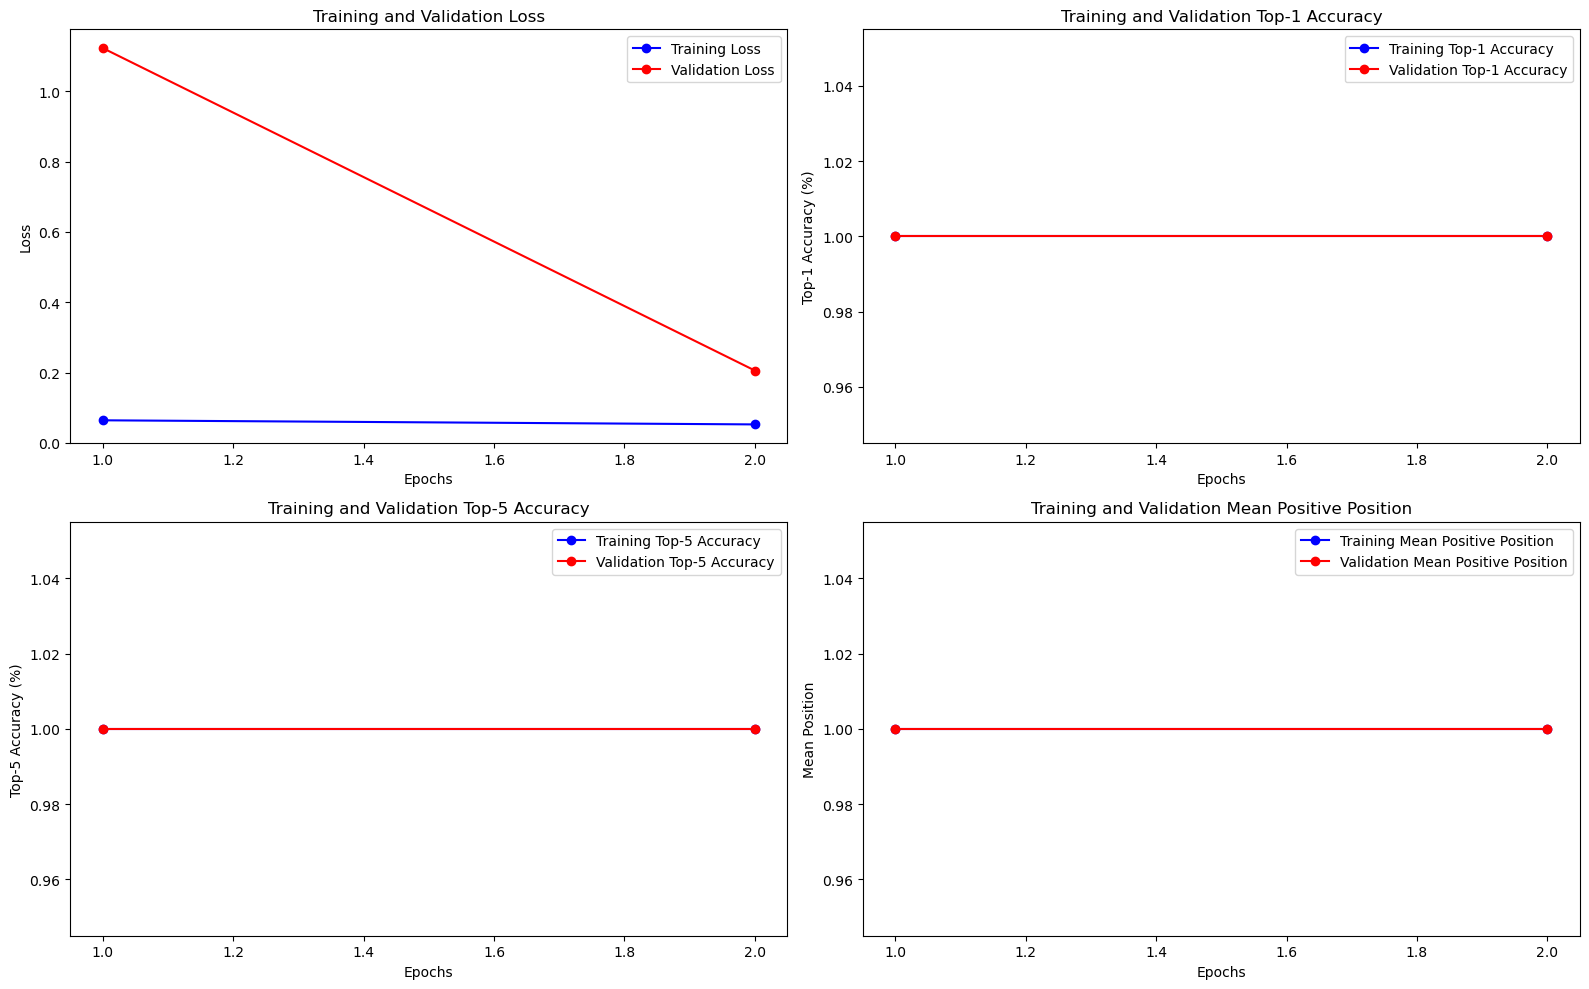

In [9]:
# Run the training script
simclr_model = train_simclr(batch_size=16, hidden_dim=128, lr=5e-4, temperature=0.07, weight_decay=1e-4, max_epochs=2)

# Logistic

In [10]:
class LabeledImageDataset(Dataset):
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform
        self.resize_transform = transforms.Resize((96, 96))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Ensure the image has 3 layers (channels)
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} does not have exactly 3 layers.")

        # Normalize the 16-bit image to [0, 1]
        image = image.astype(np.float32) / 65535.0

        # Calculate sharpness for each layer
        sharpness_scores = []
        for i in range(3):
            layer = image[i]
            gy, gx = np.gradient(layer)
            gnorm = np.sqrt(gx**2 + gy**2)
            sharpness = np.average(gnorm)
            sharpness_scores.append(sharpness)

        # Find the index of the sharpest layer
        sharpest_layer_index = np.argmax(sharpness_scores)
        
        # Determine the anchor (sharpest layer)
        anchor = image[sharpest_layer_index]

        # Convert to a torch tensor and add channel dimension
        anchor = torch.tensor(anchor, dtype=torch.float32).unsqueeze(0)
        
        # Apply resize transform
        anchor = self.resize_transform(anchor)

        label = self.labels[idx]

        return anchor, label

def load_and_split_data(root_dir, test_size=0.2):
    classes = ['untreated', 'single_dose', 'drug_screened']
    image_files = []
    labels = []

    for idx, class_name in enumerate(classes):
        class_dir = os.path.join(root_dir, class_name)
        files = [os.path.join(class_dir, file) for file in os.listdir(class_dir) if file.endswith('.tiff')]
        image_files.extend(files)
        labels.extend([idx] * len(files))
    
    # Check if the labels correctly reflect the classes
    #print("Label distribution:", {classes[i]: labels.count(i) for i in range(len(classes))})
    
    # Split data into training and test sets
    train_files, test_files, train_labels, test_labels = train_test_split(
        image_files, labels, test_size=test_size, stratify=labels, random_state=42)

    return train_files, test_files, train_labels, test_labels


# Directories for labeled data
image_dir = r"../../Data_supervised"

# Load and split the data
train_files, test_files, train_labels, test_labels = load_and_split_data(image_dir, test_size=0.2)

# Create the labeled datasets
train_labeled_dataset = LabeledImageDataset(train_files, train_labels)
test_labeled_dataset = LabeledImageDataset(test_files, test_labels)

# Define DataLoaders
batch_size = 16
train_loader_labeled = DataLoader(train_labeled_dataset, batch_size=batch_size, shuffle=True, drop_last=False, pin_memory=True, num_workers=0)
test_loader_labeled = DataLoader(test_labeled_dataset, batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=0)

In [11]:
for anchor,label in train_loader_labeled:
    print(anchor.shape, label.shape, anchor.dtype)
    print(label)
    break

torch.Size([16, 1, 96, 96]) torch.Size([16]) torch.float32
tensor([0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 2, 1, 0])


In [12]:
@torch.no_grad()
def prepare_data_features(model, dataloader):
    # Prepare model
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()  # Removing projection head g(.)
    network.eval()
    network.to(device)

    # Encode all images
    feats, labels = [], []
    for batch_imgs, batch_labels in tqdm(dataloader):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        print(f"Batch features shape: {batch_feats.shape}")
        print(f"Batch labels shape: {batch_labels.shape}")
        
        feats.append(batch_feats.detach().cpu())
        labels.append(batch_labels)

    feats = torch.cat(feats, dim=0)
    labels = torch.cat(labels, dim=0)
    
    print(f"Features shape after concatenation: {feats.shape}")
    print(f"Labels shape after concatenation: {labels.shape}")

    return torch.utils.data.TensorDataset(feats, labels)

In [13]:
# Extract features for train and test datasets
train_feats_simclr = prepare_data_features(simclr_model, train_loader_labeled)
test_feats_simclr = prepare_data_features(simclr_model, test_loader_labeled)

 25%|██▌       | 1/4 [00:03<00:10,  3.53s/it]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 50%|█████     | 2/4 [00:07<00:07,  3.52s/it]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


 75%|███████▌  | 3/4 [00:10<00:03,  3.50s/it]

Batch features shape: torch.Size([16, 512])
Batch labels shape: torch.Size([16])


100%|██████████| 4/4 [00:12<00:00,  3.13s/it]


Batch features shape: torch.Size([9, 512])
Batch labels shape: torch.Size([9])
Features shape after concatenation: torch.Size([57, 512])
Labels shape after concatenation: torch.Size([57])


100%|██████████| 1/1 [00:03<00:00,  3.31s/it]

Batch features shape: torch.Size([15, 512])
Batch labels shape: torch.Size([15])
Features shape after concatenation: torch.Size([15, 512])
Labels shape after concatenation: torch.Size([15])


In [14]:
# Logistic Regression model definition
class LogisticRegression(nn.Module):
    def __init__(self, feature_dim, num_classes):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(feature_dim, num_classes)

    def forward(self, x):
        return self.linear(x)

In [15]:
# Training function
def train_logistic_regression(model, train_loader, optimizer, scheduler, device):
    model.train()
    total_loss = 0.0
    all_preds = []
    all_labels = []

    for batch_feats, batch_labels in tqdm(train_loader, desc="Training"):
        batch_feats, batch_labels = batch_feats.to(device), batch_labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_feats)
        loss = nn.functional.cross_entropy(outputs, batch_labels)
        loss.backward()
        optimizer.step()
        
        # Update learning rate scheduler
        scheduler.step()

        total_loss += loss.item()

        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_labels.cpu().numpy())

    avg_loss = total_loss / len(train_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    return avg_loss, accuracy

In [16]:
# Evaluation function
def evaluate_logistic_regression(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch_feats, batch_labels in tqdm(test_loader, desc="Evaluating"):
            batch_feats, batch_labels = batch_feats.to(device), batch_labels.to(device)
            
            outputs = model(batch_feats)
            loss = nn.functional.cross_entropy(outputs, batch_labels)
            total_loss += loss.item()

            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_labels.cpu().numpy())

    avg_loss = total_loss / len(test_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    return avg_loss, accuracy

In [17]:
# Main training loop
def train_logreg_simplified(batch_size, train_feats_data, test_feats_data, feature_dim, num_classes, lr=5e-4, weight_decay=1e-4, max_epochs=50):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Data loaders
    train_loader = DataLoader(train_feats_data, batch_size=batch_size, shuffle=True,
                                   drop_last=False, pin_memory=True, num_workers=0) #num_workers =os.cpu_count()
    test_loader = DataLoader(test_feats_data, batch_size=batch_size, shuffle=False,
                                  drop_last=False, pin_memory=True, num_workers=0)

    # Model, loss, and optimizer
    model = LogisticRegression(feature_dim, num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer,
                                               milestones=[int(max_epochs * 0.6), int(max_epochs * 0.8)],
                                               gamma=0.1)

    # Store metrics for plotting
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    best_test_acc = 0.0
    for epoch in range(max_epochs):
        print(f"Epoch {epoch+1}/{max_epochs}")

        train_loss, train_acc = train_logistic_regression(model, train_loader, optimizer, scheduler, device)
        test_loss, test_acc = evaluate_logistic_regression(model, test_loader, criterion, device)
        
        print(f"Training loss: {train_loss:.4f}, Training accuracy: {train_acc:.4f}")
        print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}")

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

        if test_acc > best_test_acc:
            best_test_acc = test_acc
            best_model_state = model.state_dict()

    # Load best model state
    model.load_state_dict(best_model_state)

    # Plot results
    plt.figure(figsize=(15, 5))

    # Loss curve
    plt.subplot(1, 2, 1)
    plt.plot(range(max_epochs), train_losses, label='Train Loss')
    plt.plot(range(max_epochs), test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()

    # Accuracy curve
    plt.subplot(1, 2, 2)
    plt.plot(range(max_epochs), train_accuracies, label='Train Accuracy')
    plt.plot(range(max_epochs), test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model, {"train_acc": train_acc, "test_acc": test_acc}

Epoch 1/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 59.70it/s]


Training loss: 0.9682, Training accuracy: 0.3509
Test loss: 0.8100, Test accuracy: 0.6000
Epoch 2/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 112.25it/s]


Training loss: 0.7572, Training accuracy: 0.6316
Test loss: 0.6952, Test accuracy: 0.8000
Epoch 3/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 114.34it/s]


Training loss: 0.5948, Training accuracy: 0.7368
Test loss: 0.5820, Test accuracy: 0.7333
Epoch 4/50


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.4954, Training accuracy: 0.8772
Test loss: 0.5192, Test accuracy: 0.8000
Epoch 5/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 217.01it/s]


Training loss: 0.4782, Training accuracy: 0.8947
Test loss: 0.5126, Test accuracy: 0.8000
Epoch 6/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 400.72it/s]


Training loss: 0.4629, Training accuracy: 0.8947
Test loss: 0.5120, Test accuracy: 0.8000
Epoch 7/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 112.82it/s]


Training loss: 0.4344, Training accuracy: 0.8947
Test loss: 0.5115, Test accuracy: 0.8000
Epoch 8/50


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.4710, Training accuracy: 0.8947
Test loss: 0.5109, Test accuracy: 0.8000
Epoch 9/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 397.45it/s]


Training loss: 0.4569, Training accuracy: 0.8947
Test loss: 0.5103, Test accuracy: 0.8000
Epoch 10/50


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.4728, Training accuracy: 0.8947
Test loss: 0.5097, Test accuracy: 0.8000
Epoch 11/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 166.15it/s]


Training loss: 0.4480, Training accuracy: 0.8947
Test loss: 0.5091, Test accuracy: 0.8000
Epoch 12/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 126.91it/s]


Training loss: 0.4516, Training accuracy: 0.8947
Test loss: 0.5085, Test accuracy: 0.8000
Epoch 13/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 113.35it/s]


Training loss: 0.4543, Training accuracy: 0.8947
Test loss: 0.5079, Test accuracy: 0.8000
Epoch 14/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 838.11it/s]


Training loss: 0.6080, Training accuracy: 0.8947
Test loss: 0.5073, Test accuracy: 0.8000
Epoch 15/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 938.53it/s]


Training loss: 0.4514, Training accuracy: 0.8947
Test loss: 0.5064, Test accuracy: 0.8000
Epoch 16/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 501.56it/s]


Training loss: 0.4616, Training accuracy: 0.8947
Test loss: 0.5057, Test accuracy: 0.8000
Epoch 17/50


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.4511, Training accuracy: 0.8947
Test loss: 0.5052, Test accuracy: 0.8000
Epoch 18/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 500.24it/s]


Training loss: 0.4673, Training accuracy: 0.8947
Test loss: 0.5046, Test accuracy: 0.8000
Epoch 19/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 786.78it/s]


Training loss: 0.4238, Training accuracy: 0.8947
Test loss: 0.5040, Test accuracy: 0.8000
Epoch 20/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 501.20it/s]


Training loss: 0.4421, Training accuracy: 0.8947
Test loss: 0.5034, Test accuracy: 0.8000
Epoch 21/50


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.5065, Training accuracy: 0.8947
Test loss: 0.5028, Test accuracy: 0.8000
Epoch 22/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 119.86it/s]


Training loss: 0.4234, Training accuracy: 0.8947
Test loss: 0.5024, Test accuracy: 0.8000
Epoch 23/50


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.5493, Training accuracy: 0.8947
Test loss: 0.5019, Test accuracy: 0.8000
Epoch 24/50


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.4412, Training accuracy: 0.8947
Test loss: 0.5012, Test accuracy: 0.8000
Epoch 25/50


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.5623, Training accuracy: 0.8947
Test loss: 0.5006, Test accuracy: 0.8000
Epoch 26/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 109.41it/s]


Training loss: 0.4907, Training accuracy: 0.8947
Test loss: 0.4997, Test accuracy: 0.8000
Epoch 27/50


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.4428, Training accuracy: 0.8947
Test loss: 0.4989, Test accuracy: 0.8000
Epoch 28/50


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.4182, Training accuracy: 0.8947
Test loss: 0.4981, Test accuracy: 0.8000
Epoch 29/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 399.08it/s]


Training loss: 0.4434, Training accuracy: 0.8947
Test loss: 0.4975, Test accuracy: 0.8000
Epoch 30/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 130.82it/s]


Training loss: 0.4430, Training accuracy: 0.8947
Test loss: 0.4969, Test accuracy: 0.8667
Epoch 31/50


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.4962, Training accuracy: 0.8947
Test loss: 0.4963, Test accuracy: 0.8667
Epoch 32/50


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.4208, Training accuracy: 0.8947
Test loss: 0.4958, Test accuracy: 0.8667
Epoch 33/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 1189.37it/s]


Training loss: 0.4150, Training accuracy: 0.8947
Test loss: 0.4952, Test accuracy: 0.8667
Epoch 34/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 123.04it/s]


Training loss: 0.4221, Training accuracy: 0.8947
Test loss: 0.4946, Test accuracy: 0.8667
Epoch 35/50


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.4838, Training accuracy: 0.8947
Test loss: 0.4941, Test accuracy: 0.8667
Epoch 36/50


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.4068, Training accuracy: 0.8947
Test loss: 0.4935, Test accuracy: 0.8667
Epoch 37/50


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.4378, Training accuracy: 0.8947
Test loss: 0.4929, Test accuracy: 0.8667
Epoch 38/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 114.41it/s]


Training loss: 0.4566, Training accuracy: 0.8947
Test loss: 0.4923, Test accuracy: 0.8667
Epoch 39/50


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.4283, Training accuracy: 0.8947
Test loss: 0.4918, Test accuracy: 0.8667
Epoch 40/50


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.4243, Training accuracy: 0.8947
Test loss: 0.4913, Test accuracy: 0.8667
Epoch 41/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 478.01it/s]


Training loss: 0.4236, Training accuracy: 0.8947
Test loss: 0.4907, Test accuracy: 0.8667
Epoch 42/50


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.4300, Training accuracy: 0.8947
Test loss: 0.4902, Test accuracy: 0.8667
Epoch 43/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 754.85it/s]


Training loss: 0.4181, Training accuracy: 0.8947
Test loss: 0.4896, Test accuracy: 0.8667
Epoch 44/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 146.45it/s]


Training loss: 0.4284, Training accuracy: 0.8947
Test loss: 0.4891, Test accuracy: 0.8667
Epoch 45/50


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.4867, Training accuracy: 0.8947
Test loss: 0.4884, Test accuracy: 0.8667
Epoch 46/50


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.4475, Training accuracy: 0.8947
Test loss: 0.4879, Test accuracy: 0.8667
Epoch 47/50


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.4592, Training accuracy: 0.8947
Test loss: 0.4872, Test accuracy: 0.8667
Epoch 48/50


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 113.76it/s]


Training loss: 0.3999, Training accuracy: 0.8947
Test loss: 0.4864, Test accuracy: 0.8667
Epoch 49/50


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.4217, Training accuracy: 0.8947
Test loss: 0.4858, Test accuracy: 0.8667
Epoch 50/50


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.4045, Training accuracy: 0.8947
Test loss: 0.4852, Test accuracy: 0.8667


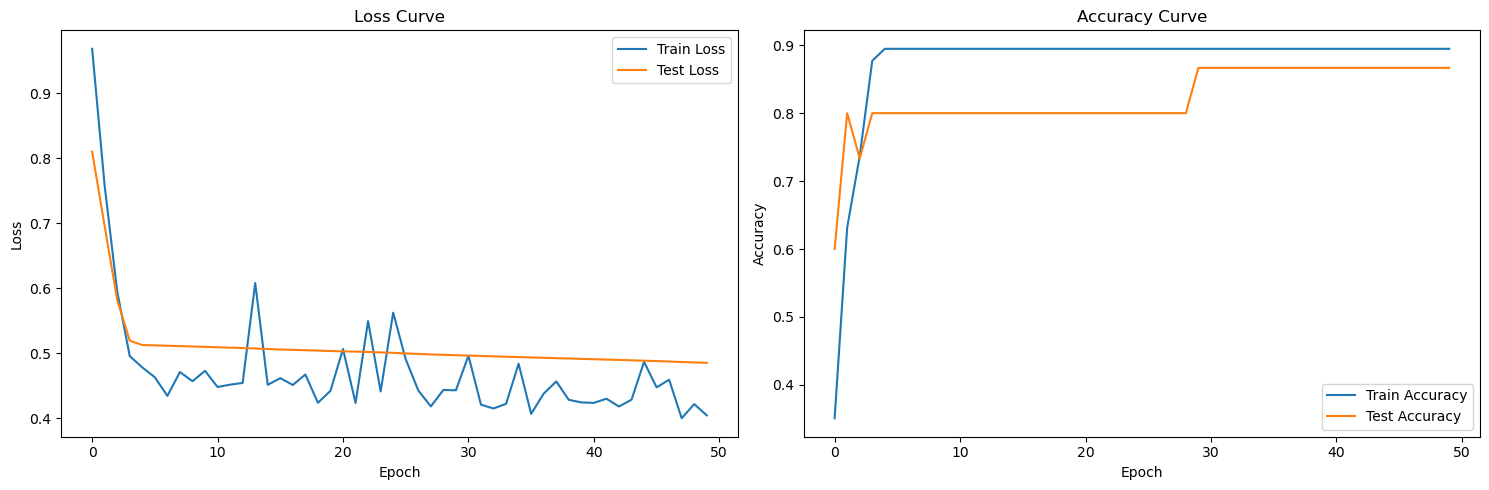

In [18]:
# Train the logistic regression model
logreg_model, results = train_logreg_simplified(
    batch_size=8,
    train_feats_data=train_feats_simclr,
    test_feats_data=test_feats_simclr,
    feature_dim=train_feats_simclr.tensors[0].shape[1],
    num_classes=3,
    lr=5e-4,
    weight_decay=1e-4,
    max_epochs=50
)

#print(f"Final Train Accuracy: {results['train_acc']:.4f}, Final Test Accuracy: {results['test_acc']:.4f}")
